In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from prophet import Prophet
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Preprocessing

df = pd.read_csv('bike_sharing_training.csv')
df.rename(columns={'cnt': 'y', 'dteday': 'ds'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%m/%d/%Y')
df[['weathersit_2', 'weathersit_3']] = pd.get_dummies(df['weathersit'], drop_first=True)
df.drop(columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered', 'weathersit'], 
        inplace=True)  # Remove unneeded variables

df.set_index('ds', inplace=True)
df.index.freq = 'D'

## Exploratory Data Analysis

<Axes: xlabel='ds'>

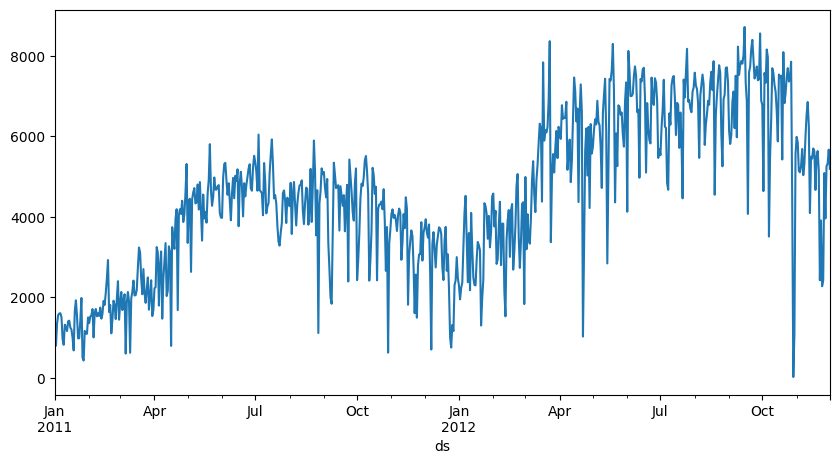

In [4]:
plt.figure(figsize=(10, 5))
df['y'].plot()

In [5]:
# Which factors are correlated with the daily count of shared bikes?

df.corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
atemp,0.633885
temp,0.631649
workingday,0.048162
holiday,-0.058080
hum,-0.101409
weathersit_2,-0.166746
windspeed,-0.234871
weathersit_3,-0.234874


In [6]:
#What is the significance level of the variable associations with y?

{'atemp': pearsonr(df['y'], df['atemp'])[1], \
'temp': pearsonr(df['y'], df['temp'])[1], \
'windspeed': pearsonr(df['y'], df['windspeed'])[1], \
'hum': pearsonr(df['y'], df['hum'])[1]}

{'atemp': 4.808082149653423e-80,
 'temp': 2.5097397796383583e-79,
 'windspeed': 3.05974963187083e-10,
 'hum': 0.007207881612862129}

In [7]:
# What is the mean count for each weathersit?
df.pivot_table(index=['weathersit_2', 'weathersit_3'], values='y', aggfunc='mean').reset_index()

,weathersit_2,weathersit_3,y
0,False,False,4881.733925
1,False,True,1871.400000
2,True,False,4065.508696


In [8]:
# What is the significance level of the difference of the means? (For weathersits 2 and 3) 
f_oneway(df[df['weathersit_2'] == True]['y'], 
         df[df['weathersit_3'] == True]['y'])[1]

2.9835810336291315e-07

In [9]:
# What is the mean count for each workingday status?
df.pivot_table(index='workingday', values='y', aggfunc='mean')

,y
workingday,
0,4390.457014
1,4591.387500


In [10]:
# What is the significance level of the difference of the means?
f_oneway(df[df['workingday'] == 1]['y'], 
         df[df['workingday'] == 0]['y'])[1]

0.20279756941426727

In [11]:
# What is the mean count for each workingday status?
df.pivot_table(index='holiday', values='y', aggfunc='mean')

,y
holiday,
0,4547.334802
1,3871.100000


In [12]:
# What is the significance level of the difference of the means?
f_oneway(df[df['holiday'] == 1]['y'], 
         df[df['holiday'] == 0]['y'])[1]

0.12446261388088206

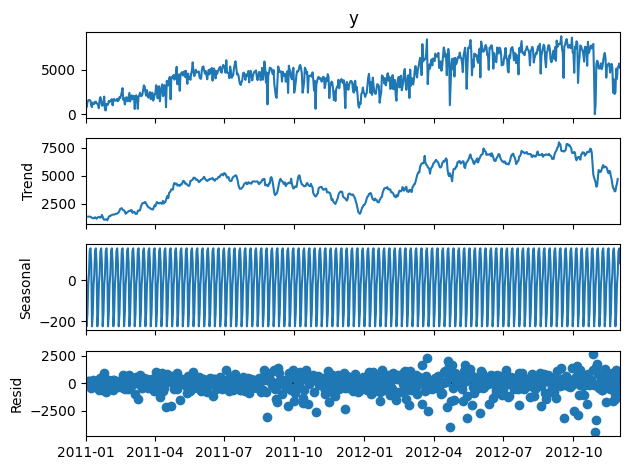

In [13]:
y_decompose = seasonal_decompose(df['y'], model='additive',
                   period=7)

y_decompose.plot()
plt.show()

<Axes: xlabel='ds'>

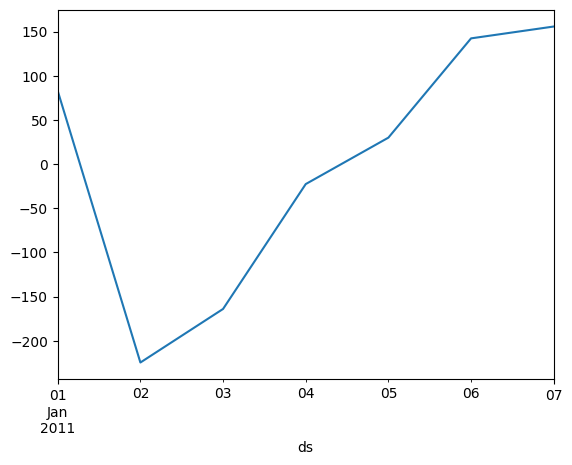

In [14]:
y_decompose.seasonal[:7].plot()

In [ ]:
plot_acf(df['y'], lags=100);
plot_pacf(df['y'], lags=20);

In [57]:
def add_holiday(holiday, holiday_date):

    if holiday_date.__class__ == str:
        ds = pd.to_datetime(['2011-'+holiday_date, '2012-'+holiday_date])
    
    elif holiday_date.__class__ == list:
        ds = pd.to_datetime(holiday_date)
    
    elif holiday_date.__class__ == pd.core.indexes.datetimes.DatetimeIndex:
        ds = holiday_date

    holiday_df = pd.DataFrame({'holiday': holiday,
                              'ds': ds,
                              'lower_window': -3,
                              'upper_window': 3})
    
    return holiday_df

In [ ]:
gen_holidays = add_holiday('gen_holi', df[df['holiday']==1].index)
xmas = add_holiday('christmas', '12-24')
nye = add_holiday('new_year', '12-31')
easter = add_holiday('easter', ['2011-04-24', '2012-04-08'])

#Combine holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter]).set_index('ds')

holidays.sort_index()#.asfreq('D')

In [59]:
holidays.reset_index(inplace=True)
df.reset_index(inplace=True)

## Prophet Model

In [ ]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

In [61]:
from prophet.utilities import regressor_coefficients

In [ ]:
regressor_coefficients(model)

In [ ]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

In [ ]:
from prophet.diagnostics import performance_metrics
performance_metrics(df_cv)

In [ ]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

In [ ]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='mape');

In [67]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']

In [ ]:
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y']) - 1
df_cv.sort_values('deviation_%', ascending=False).head(10)

# On October 29th, 2012, Hurricane Sandy assaulted Washington D.C.

In [69]:
df.loc[df['ds']=='2012-10-29', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']
df.loc[df['ds']=='2012-10-30', 'y'] = df.loc[df['ds']=='2012-10-28', 'y']

In [ ]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')

model.fit(df)

In [ ]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

In [ ]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

In [ ]:
plot_cross_validation_metric(df_cv, metric='mape');

## Feature Engineering

In [ ]:
for lag in range(1, 9, 2):
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag)

df.corr()[['y']]

In [ ]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

model.add_regressor('workingday')
model.add_regressor('atemp')
model.add_regressor('temp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weathersit_2')
model.add_regressor('weathersit_3')
model.add_regressor('temp_lag_1')

model.fit(df.dropna())

In [ ]:
from prophet.diagnostics import cross_validation

# Apply CV to the model

df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')

df_cv

In [ ]:
{'rmse': performance_metrics(df_cv)['rmse'].mean(),
 'mape': performance_metrics(df_cv)['mape'].mean()}

## Parameter Tuning

In [78]:
from sklearn.model_selection import ParameterGrid

param_grid = {'changepoint_prior_scale': [0.05, 0.5],
              'seasonality_prior_scale': [10, 20],
              'holidays_prior_scale':[10, 20],
              'seasonality_mode': ['additive', 'multiplicative']}

all_params = list(ParameterGrid(param_grid))

In [ ]:
tuning_results = []

for params in all_params:
    
    model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                holidays = holidays,
                seasonality_mode = params['seasonality_mode'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                changepoint_prior_scale=params['changepoint_prior_scale'])

    model.add_regressor('workingday')
    model.add_regressor('atemp')
    model.add_regressor('temp')
    model.add_regressor('hum')
    model.add_regressor('windspeed')
    model.add_regressor('weathersit_2')
    model.add_regressor('weathersit_3')
    model.add_regressor('temp_lag_1')

    model.fit(df.dropna())

    df_cv = cross_validation(model=model,
                         period='15 days',
                         initial=f'{df.shape[0]-180} days',
                         horizon='30 days',
                         parallel='processes')


    metrics = {'rmse': performance_metrics(df_cv)['rmse'].mean(),
    'mape': performance_metrics(df_cv)['mape'].mean()}

    tuning_results.append(metrics)

In [ ]:
outcomes = pd.DataFrame(all_params)
outcomes['rmse'] = [x['rmse'] for x in tuning_results]
outcomes['mape'] = [x['mape'] for x in tuning_results]
best_params = all_params[outcomes.query('rmse == rmse.min()').index.to_list()[0]]
best_params